# スポーツジムの顧客データを分析２
今回は、機械学習を用いて顧客のグループ化や顧客の利用予測を行なっていきます。

## ライブラリ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
import sklearn.model_selection

## データ読み込み

In [2]:
uselog = pd.read_csv('use_log.csv')         # 顧客の利用履歴データ
customer = pd.read_csv('customer_data.csv') # 前回作成した顧客データ

## クラスタリングで顧客をグループ化

In [3]:
# クラスタリング用のデータ抽出
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [4]:
# K-meansモデル構築
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 1 0 2]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


## クラスタリング結果を分析

In [5]:
# クラスタ毎に集計(集計しやすくするためにカラム名変更)
customer_clustering.columns = ["月内平均値","月内中央値", "月内最大値", "月内最小値","会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,1336,1336,1336,1336,1336
1,761,761,761,761,761
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [6]:
# 平均値集計
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,5.522518,5.373129,8.743263,2.686377,14.831587
1,3.051243,2.885677,4.750329,1.653088,9.269382
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


- グループ0 &nbsp; : &nbsp;会員期間が長く、利用率が高いグループ  
- グループ1 &nbsp;&thinsp; : &nbsp;会員期間が短く,最も利用率が少ないグループ  
- グループ2 &nbsp; : &nbsp;会員期間が短く、最も利用率が高いグループ  
- グループ3 &nbsp; : &nbsp;最も会員期間が長く、利用率が少ないグループ

## クラスタリング結果を可視化

In [7]:
# 主成分分析で2次元に削減したデータ作成
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

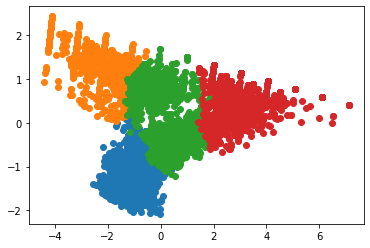

In [8]:
# グラフで可視化
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

## クラスタリング結果をもとに退会顧客の傾向を分析

In [9]:
# 退会顧客をグループ毎に集計
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,551
2,1,1,761
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [10]:
# 定期利用顧客をグループ毎に集計
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,229
1,0,1,1107
2,1,0,496
3,1,1,265
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


- グループ0 &nbsp; : &nbsp;退会顧客と継続顧客のバランス良く、定期利用者が多いグループ
- グループ1 &nbsp;&thinsp; : &nbsp;退会顧客が多く定期利用者が少ないグループ   
- グループ2 &nbsp; : &nbsp; 継続顧客が多く定期利用者が多いグループ 
- グループ3 &nbsp; : &nbsp; 継続顧客が多く定期利用者が多いグループ  
  
### 前回と同様に継続顧客、退会顧客と定期利用者には相関性がある様に考えられます。

## 翌月の利用回数予測を行うためのデータを準備

In [11]:
# 年月、顧客毎利用データ
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [12]:
# 2018-10 ~ 2019-3までの過去６ヶ月の利用データ
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


- 2018-10 ~ 2019-3までの過去６ヶ月以内に退会してしまった人には欠損値が入っています。

In [13]:
# 過去6ヶ月内に退会してしまったデータを除去
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


## 特徴となる変数を付与

In [14]:
# predict_dataとcustomerのstart_dateカラムを結合
predict_data = pd.merge(predict_data, customer[["customer_id","start_date"]], on="customer_id", how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [15]:
# 会員期間カラム作成
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


## 来月の利用回数予測モデルを作成
線形回帰モデルで、学習用データ、評価用データに分割して学習を行います。

In [16]:
# 線形回帰モデル作成(説明変数:X, 目的変数:Y, 学習用データ:75%, 評価データ:25%)
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]

model = linear_model.LinearRegression()
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

LinearRegression()

In [17]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6066629330622303
0.609374121377603


## モデルに寄与している変数を確認

In [18]:
# 説明変数毎に係数を表示
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.327889
1,count_1,0.184203
2,count_2,0.163543
3,count_3,0.198398
4,count_4,0.085430
5,count_5,0.075132
6,period,0.097122


- count_0の係数が最も大きく、過去に遡るほど小さくなっているため、直近の利用回数が翌月の利用回数に大きく影響していると考えられます。

## 来月の利用回数を予測

In [19]:
# 2人の6ヶ月前からの利用履歴をリストに格納
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [20]:
# モデルを使って予測
model.predict(x_pred)

array([3.87992117, 2.00803769])

- 1人目は約3.8回、2人目は約2回来ることが予測されました。

## 次回は、スポーツジムの退会予測を行います。

In [21]:
# 次回利用するデータを書き出し
uselog_months.to_csv("result/use_log_months.csv",index=False)